In [66]:
import pandas as pd
import numpy as np
base = "../../data/"
nswdf_target = pd.read_csv(base+"clean/filtered_nonlog_target.csv", index_col=0)
nswdf_target.columns

Index(['LGA', 'Assault - domestic violence', 'Assault - non-domestic violence',
       'Fraud', 'Sexual Offences', 'Malicious damage to property',
       'Prohibited weapons offences'],
      dtype='object')

In [67]:
nswdf_target

,LGA,Assault - domestic violence,Assault - non-domestic violence,Fraud,Sexual Offences,Malicious damage to property,Prohibited weapons offences
362,Albury,544.4263,563.5963,525.2564,216.6203,1315.0580,316.3040
363,Armidale Regional,501.4681,653.2282,841.2787,221.0419,2217.0169,287.0245
364,Ballina,255.7125,321.4001,504.3870,154.8351,795.2893,152.4891
365,Bathurst Regional,438.7931,462.3841,686.4989,200.5237,1184.2695,226.4738
366,Bayside,315.9874,274.1388,728.4085,85.5167,584.6676,108.5638
367,Bega Valley,312.2606,341.7192,318.1524,153.1845,810.1102,153.1845
368,Bellingen,279.2213,263.7090,248.1967,116.3422,604.9794,93.0738
369,Berrigan,174.9883,139.9907,163.3224,81.6612,699.9533,279.9813
370,Blacktown,594.3767,453.1188,821.0799,163.9858,980.7504,148.7380
371,Bland,348.2010,315.0390,281.8770,215.5530,746.1449,381.3630


In [68]:
opal_df = pd.read_csv(base+"clean/opal_lgas.csv")
opal_lgas = opal_df["lga"].unique()

/Users/desultir/git/capstone/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
import datetime
opal_df["dayofweek"] = opal_df["date"].apply(lambda x: datetime.datetime.strptime(str(x), "%Y%M%d").weekday())

In [5]:
set(opal_lgas).difference(set(nswdf_target["LGA"].unique()))

set()

In [6]:
outdfs = []
for weekday in range(7):
    for tod in ("night", "morning", "afternoon", "evening"):
        for tap in ("on","off"):
            aggdf = opal_df[(opal_df["dayofweek"]==weekday) & (opal_df[tod]==1) & (opal_df["tap"]==tap)].groupby(["lga"]).sum()[["count"]]
            aggdf = aggdf.rename(columns={"count": "{0},{1},{2}".format(weekday,tod,tap)})
            outdfs.append(aggdf)

In [7]:
featuredf = outdfs[0]
for df in outdfs[1:]:
    featuredf = featuredf.join(df, how="outer")
featuredf = featuredf.fillna(0)

In [69]:
master_df = featuredf.join(nswdf_target.set_index("LGA"))
master_df = master_df.where((master_df == 0).astype(int).sum(axis=1) < 15).dropna()
master_df

,"0,night,on","0,night,off","0,morning,on","0,morning,off","0,afternoon,on","0,afternoon,off","0,evening,on","0,evening,off","1,night,on","1,night,off",...,"6,afternoon,on","6,afternoon,off","6,evening,on","6,evening,off",Assault - domestic violence,Assault - non-domestic violence,Fraud,Sexual Offences,Malicious damage to property,Prohibited weapons offences
lga,,,,,,,,,,,,,,,,,,,,,
Bayside,3395.0,1510.0,60002.0,34005.0,42997.0,43966.0,11341.0,33747.0,3628.0,2267.0,...,33212.0,33764.0,9172.0,25430.0,315.9874,274.1388,728.4085,85.5167,584.6676,108.5638
Blacktown,6761.0,1615.0,85799.0,39284.0,49351.0,68544.0,10280.0,35716.0,6609.0,1975.0,...,32614.0,42619.0,6166.0,22314.0,594.3767,453.1188,821.0799,163.9858,980.7504,148.7380
Blue Mountains,433.0,0.0,7293.0,3924.0,5701.0,6123.0,67.0,2757.0,416.0,0.0,...,6641.0,6036.0,173.0,1345.0,317.6418,254.1135,398.9581,177.8794,750.9053,104.1865
Burwood,606.0,333.0,20037.0,15269.0,20012.0,19747.0,7247.0,12026.0,613.0,496.0,...,17019.0,16145.0,5948.0,9864.0,187.0373,342.9017,1467.7231,111.7028,527.3412,70.1390
Camden,98.0,0.0,3051.0,594.0,801.0,1883.0,0.0,1066.0,110.0,0.0,...,545.0,1135.0,0.0,663.0,277.1012,218.6987,547.9895,109.3494,550.4747,100.6511
Campbelltown,4625.0,106.0,34171.0,10417.0,12966.0,23222.0,1017.0,16490.0,4696.0,261.0,...,8503.0,15082.0,545.0,9918.0,578.0347,446.6913,689.5526,214.9818,1084.8218,201.3518
Canada Bay,426.0,255.0,28448.0,14459.0,17551.0,19149.0,4136.0,14373.0,368.0,363.0,...,14148.0,14688.0,2868.0,9764.0,116.9059,149.3797,760.9708,61.7003,351.8001,44.3809
Canterbury-Bankstown,4120.0,413.0,81174.0,29260.0,43652.0,61956.0,5319.0,31597.0,4289.0,727.0,...,27149.0,37792.0,3092.0,18691.0,372.2850,290.6920,748.7187,88.2310,568.3845,123.3574
Central Coast,3631.0,490.0,36814.0,21009.0,26202.0,29496.0,1786.0,11319.0,3535.0,565.0,...,16957.0,19083.0,900.0,6994.0,524.5908,440.4892,612.8675,206.9733,1046.4974,150.0109


In [73]:

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

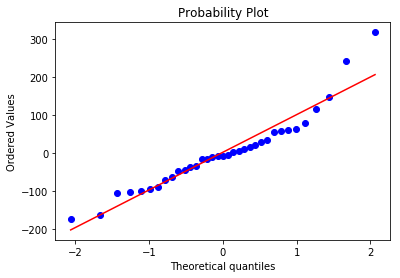

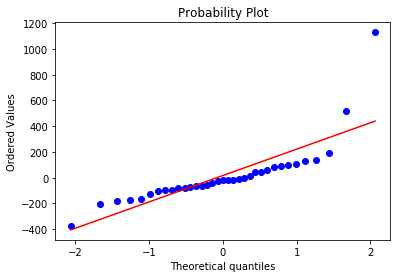

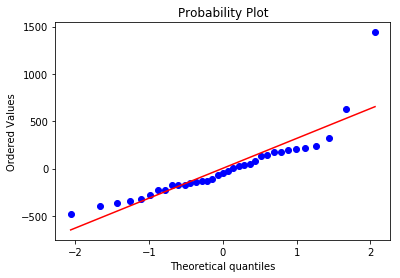

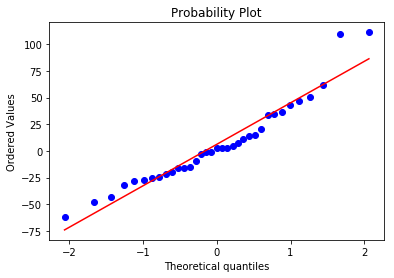

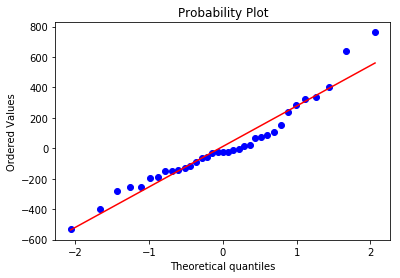

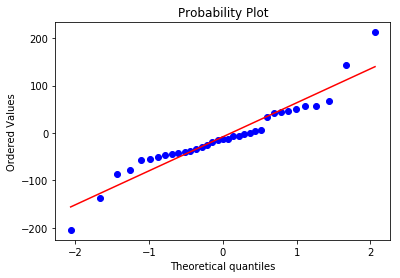

In [90]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import probplot
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize

def kfold_cv(k, crimenum, dataframe):
    lga_names = dataframe.index.unique()
    start_col = dataframe.columns.get_loc("Assault - domestic violence")
    kf = KFold(n_splits=5, shuffle=True)
    models = []
    rmse = []
    mape = []
    r2 = []
    allpreds = []
    output = pd.DataFrame(index=range(len(dataframe)))
    for train_index, test_index in kf.split(lga_names):
        train_lgas = lga_names[train_index]
        traindf = dataframe.loc[train_lgas].iloc[:,:start_col]
        train_target = dataframe.loc[dataframe.index.isin(train_lgas)].iloc[:,start_col+crimenum]
        
        test_lgas = lga_names[test_index]
        testdf = dataframe.loc[test_lgas].iloc[:,:start_col]
        test_target = dataframe.loc[dataframe.index.isin(test_lgas)].iloc[:,start_col+crimenum]
        #import pdb; pdb.set_trace()
        model = RandomForestRegressor()
        model.fit(normalize(traindf), train_target)
        models.append(model)
        #print(lga_loc)
        preds = model.predict(normalize(testdf))
        preds_series = pd.Series(preds)
        #import pdb; pdb.set_trace()
        preds_series.index = test_target.index
        
        allpreds.append(pd.DataFrame({"preds": preds_series, "target": test_target}))
        
        mape.append(mean_absolute_percentage_error(preds, test_target))
        rmse.append(np.sqrt(mean_squared_error(preds, test_target)))
        r2.append(r2_score(test_target, preds))

    allpreds_df = pd.concat(allpreds)
    #import pdb; pdb.set_trace()
    probplot(allpreds_df["target"] - allpreds_df["preds"], dist='norm', plot=plt)

    plt.show()
    mape.append(mean_absolute_percentage_error(allpreds_df["preds"], allpreds_df["target"]))
    rmse.append(np.sqrt(mean_squared_error(allpreds_df["preds"], allpreds_df["target"])))
    r2.append(r2_score(allpreds_df["target"], allpreds_df["preds"]))
    return output, rmse, r2, models, mape, allpreds_df

outputs = []
for target in range(6):
    outputs.append(kfold_cv(5, target, master_df))

In [91]:
[x[4][-1] for x in outputs]

[30.504617088323283,
 44.91442992248839,
 30.51370714027099,
 24.333691316102684,
 30.954737234857767,
 46.9480775911868]

In [87]:
for i,x in enumerate(outputs):
    x[-1]["mean"] = x[-1]["target"].mean()
    print(nswdf_target.columns[i+1],":", x[4][-1],",", mean_absolute_percentage_error(x[-1]["target"], x[-1]["mean"]))

Assault - domestic violence : 27.097883007172197 , 65.68586951122087
Assault - non-domestic violence : 48.438686211690246 , 55.33011333765459
Fraud : 32.36768429764085 , 35.21376463117899
Sexual Offences : 30.590814334553514 , 41.11235831286913
Malicious damage to property : 27.98140732382805 , 37.50460396364726
Prohibited weapons offences : 45.2343636008085 , 120.99008862860595


,LGA,Assault - domestic violence,Assault - non-domestic violence,Fraud,Sexual Offences,Malicious damage to property,Prohibited weapons offences
362,Albury,6.299733,6.334338,6.263887,5.378146,7.181636,5.756704
363,Armidale Regional,6.217540,6.481927,6.734923,5.398352,7.703918,5.659568
364,Ballina,5.544054,5.772687,6.223344,5.042361,6.678706,5.027093
365,Bathurst Regional,6.084028,6.136396,6.531605,5.300932,7.076881,5.422629
366,Bayside,5.755702,5.613635,6.590862,4.448712,6.371043,4.687338
367,Bega Valley,5.743838,5.833989,5.762531,5.031643,6.697170,5.031643
368,Bellingen,5.632005,5.574846,5.514222,4.756536,6.405194,4.533393
369,Berrigan,5.164719,4.941576,5.095726,4.402579,6.551014,5.634723
370,Blacktown,6.387513,6.116154,6.710620,5.099780,6.888318,5.002186
371,Bland,5.852780,5.752696,5.641471,5.373207,6.614920,5.943752


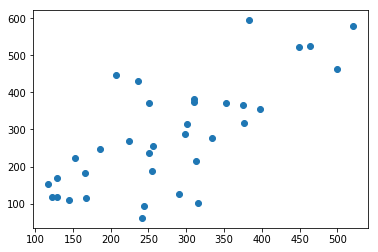

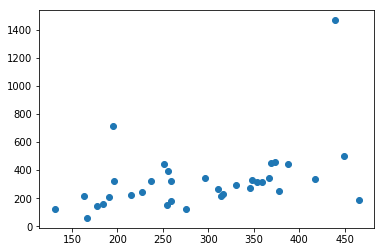

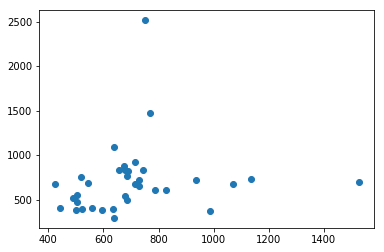

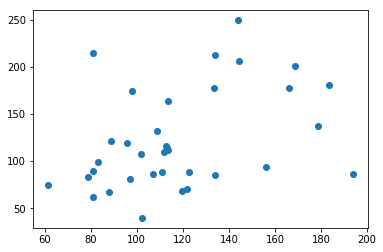

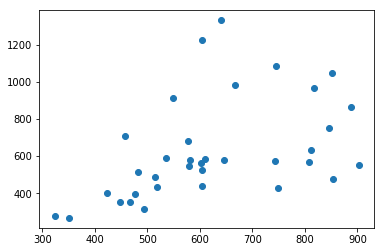

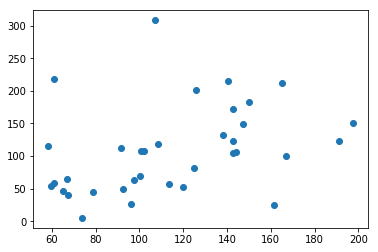

In [83]:
for i in range(len(outputs)):
    plt.scatter(outputs[i][-1].iloc[:,0], outputs[i][-1].iloc[:,1])
    plt.show()